### Want to look at how the softmax temperature (or beta) prob dist of beliefs
- How close can we get to the reported prob of choice in the model? 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *

import seaborn as sns
import scipy.stats


In [2]:
num_bins = 2
beta_vals = np.arange(1, 20, 0.2)


def get_sess_beh(row, beh_path):
    session = row.session_name
    behavior_path = beh_path.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # # filter trials 
    beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_feature_values_per_session(session, beh)
    probs_path = f"/data/082023_RL_Probs/sess-{session}_hv.csv"
    probs = pd.read_csv(probs_path)
    beh = pd.merge(beh, probs[["trial", "Prob_FE"]], left_on="TrialNumber", right_on="trial", how="inner")
    for i, beta in enumerate(beta_vals):
        beh = behavioral_utils.calc_feature_probs(beh, beta)
        def calc_err(row):
            return (row[f"{row.Color}Prob"] + row[f"{row.Shape}Prob"] + row[f"{row.Pattern}Prob"] - row.Prob_FE) ** 2
        beh[f"ProbSE{i}"] = beh.apply(calc_err, axis=1)
    beh["session"] = session
    return beh

In [3]:
# Monkey S
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)
beh_path = SESS_BEHAVIOR_PATH
all_beh = pd.concat(sessions.apply(lambda x: get_sess_beh(x, beh_path), axis=1).values).reset_index()

In [4]:
res = []
for i, beta_val in enumerate(beta_vals):
    mse = all_beh[f"ProbSE{i}"].sum()
    res.append({"beta": beta_val, "mse": mse})
res = pd.DataFrame(res)

<Axes: xlabel='beta', ylabel='mse'>

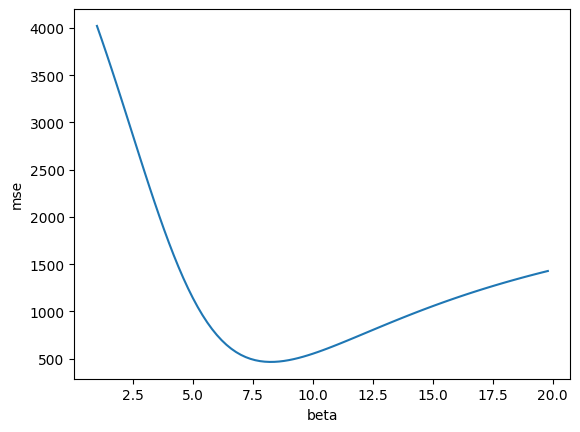

In [5]:
sns.lineplot(res, x="beta", y="mse")

In [9]:
res.mse.min() / 28013

0.01659308851572005

In [11]:
res.mse.idxmin()

36

In [13]:
res.iloc[36]

beta      8.200000
mse     464.822189
Name: 36, dtype: float64